## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

In [23]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import binary_fill_holes as bfh
from tabulate import tabulate
from scipy.spatial import distance
from skimage import io, morphology, measure
from skimage.measure import label, regionprops



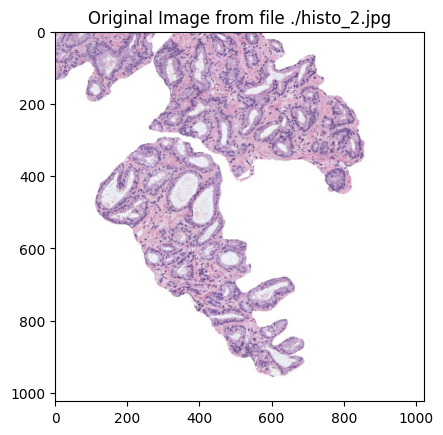

Original Image type: uint8
Original Image pixel max value: 255

Normalized Image type: float64
Normalized Image pixel max value 1.0


In [2]:
img_file = './histo_2.jpg'
#img_file = './histo_1.jpg'
img = io.imread(img_file)

img_norm = img.copy().astype('uint8')/255

plt.title(f"Original Image from file {img_file}")
plt.imshow(img_norm)
plt.show()

print(f"Original Image type: {img.dtype}")
print(f"Original Image pixel max value: {img.max()}")
print()
print(f"Normalized Image type: {img_norm.dtype}")
print(f"Normalized Image pixel max value {img_norm.max()}")


#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

In [ ]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

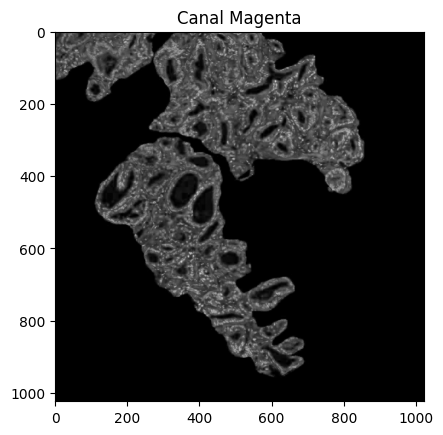

In [3]:
with np.errstate(invalid='ignore', divide='ignore'):

    R = img_norm[:,:,0]
    G = img_norm[:,:,1]
    B = img_norm[:,:,2]

    K = 1 - np.max(img_norm, axis=2)
    # Extrae los canales de acuerdo con la ecuación del power point
    C = (1-R-K)/(1-K)
    M = (1-G-K)/(1-K)
    Y = (1-B-K)/(1-K)

CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')
C,M,Y,K = cv2.split(CMYK)

plt.imshow(M.astype('uint8'), cmap='gray')
plt.title('Canal Magenta')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

In [ ]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante

Original Input Image type: uint8
Original Input pixel max value: 255


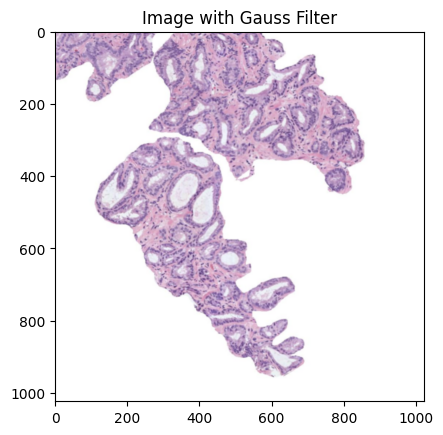

Gaus Output Image type: uint8
Gaus Output Image pixel max value: 255


In [4]:
# Filtro Gaussiano de 5x5

print(f"Original Input Image type: {img.dtype}")
print(f"Original Input pixel max value: {img.max()}")

img_gaus = cv2.GaussianBlur(img, (5,5), 0) # (5x5) es el tamaño del filtro y 0 es la desviación estándar
plt.title('Image with Gauss Filter')
plt.imshow(img_gaus)
plt.show()


print(f"Gaus Output Image type: {img_gaus.dtype}")
print(f"Gaus Output Image pixel max value: {img_gaus.max()}")

Gaus Input Image type: uint8
Gaus Input Image pixel max value: 255
Gaus Gray Image type: uint8
Gaus Gray Image pixel max value: 255


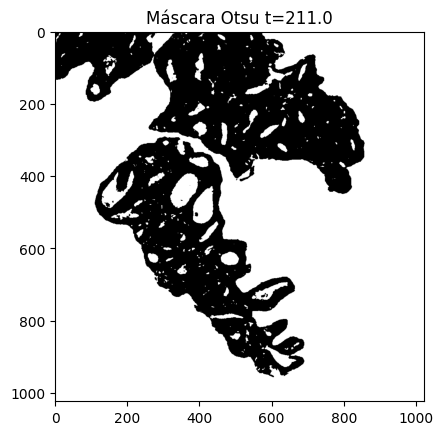

Mask Output Image type: uint8
Mask Output pixel max value: 1


In [5]:
# Convert the guassian image to gray

print(f"Gaus Input Image type: {img_gaus.dtype}")
print(f"Gaus Input Image pixel max value: {img_gaus.max()}")

img_gaus_gray = cv2.cvtColor(img_gaus, cv2.COLOR_BGR2GRAY)

print(f"Gaus Gray Image type: {img_gaus_gray.dtype}")
print(f"Gaus Gray Image pixel max value: {img_gaus_gray.max()}")

# Obtain OTSU mask
# 0 is for black, and 1 is for white
# the mask image where pixels are either 0 (black) or 1 (white)
t, img_otsu_mask = cv2.threshold(img_gaus_gray,0,1,cv2.THRESH_OTSU)

# Visualizamos para corroborar que se obtiene el mismo resultado
plt.imshow(img_otsu_mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()

print(f"Mask Output Image type: {img_otsu_mask.dtype}")
print(f"Mask Output pixel max value: {img_otsu_mask.max()}")


#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

In [ ]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

OTSU Mask Input Image type: uint8
OTSU Mask Input pixel max value: 1


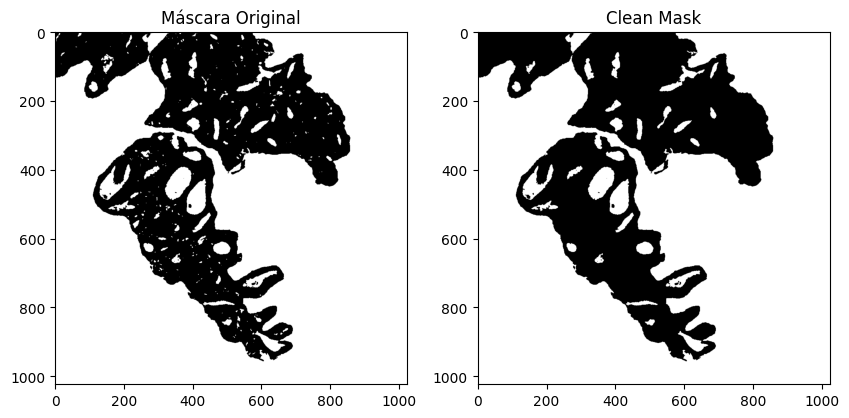

OTSU Clean Mask Image type: uint8
OTSU Clean Mask pixel max value: 255


In [6]:
# --- Code to remove small objects ---
# The remove_small_objects function works with boolean or labeled images.
# We first convert the mask to boolean and set min_size to 300.

img_otsu_clean = morphology.remove_small_objects(img_otsu_mask.astype(bool), min_size=300)

print(f"OTSU Mask Input Image type: {img_otsu_mask.dtype}")
print(f"OTSU Mask Input pixel max value: {img_otsu_mask.max()}")

# The result is a boolean array. You can convert it back to uint8 if needed.
img_otsu_clean = img_otsu_clean.astype(np.uint8) * 255

# Visualize the masks to see the result
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(img_otsu_mask, cmap='gray')
ax[0].set_title('Máscara Original')

ax[1].imshow(img_otsu_clean, cmap='gray')
ax[1].set_title('Clean Mask')

plt.show()

print(f"OTSU Clean Mask Image type: {img_otsu_clean.dtype}")
print(f"OTSU Clean Mask pixel max value: {img_otsu_clean.max()}")


In [7]:
# Calculate the number of regions with less than 300 pixels
# and the number of regios with more or equal to 300 pixels

# Label the connected objects in your binary image
label_image = measure.label(img_otsu_mask)

# Find properties for each labeled object
regions = measure.regionprops(label_image)

# Initialize counters
small_regions = 0
large_regions = 0

# Iterate through each detected region and count based on area
for region in regions:
    if region.area < 300:
        small_regions += 1
    else:
        large_regions += 1

# Print the final counts
print(f"Regions with less than 300 pixels: {small_regions}")
print(f"Regions with more or equal to 300 pixels: {large_regions}")

Regions with less than 300 pixels: 277
Regions with more or equal to 300 pixels: 29


#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

In [ ]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

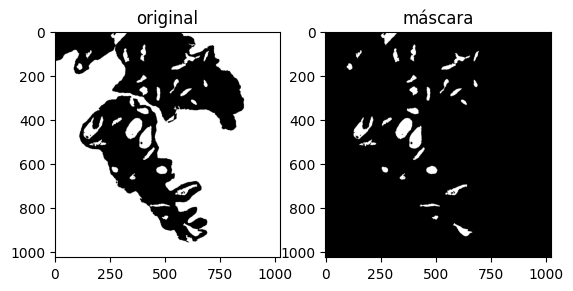

In [8]:
# Crear una copia de la imagen
img_otsu_clean_expansion = img_otsu_clean.copy()

# Definir una imagen negra de referencia
h, w = img_otsu_clean.shape
ref = np.zeros((h+2, w+2), np.uint8)

seed1 = (0,0)
seed2 = (h-1, w-1)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
cv2.floodFill(img_otsu_clean_expansion, ref, seed1, 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición

cv2.floodFill(img_otsu_clean_expansion, ref, seed2, 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_otsu_clean, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(img_otsu_clean_expansion, cmap='gray'), ax[1].set_title('máscara')
plt.show()



#### 5) Rellenar los objetos de los lúmenes

In [ ]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

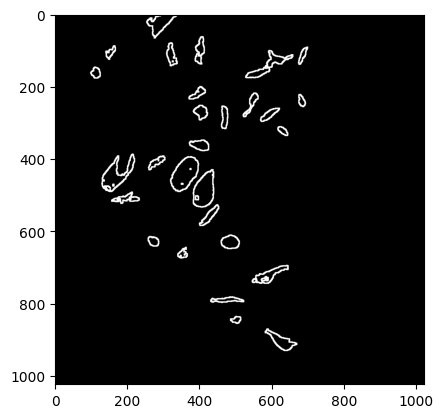

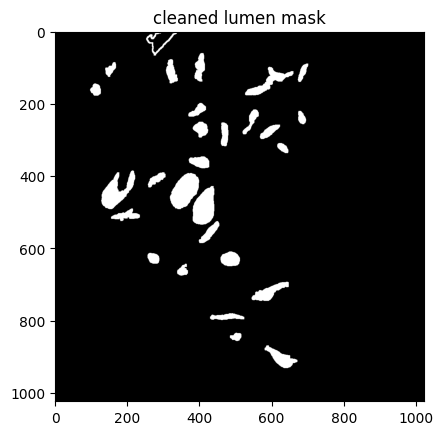

In [9]:
# Detección de bordes de Canny
img_canny = cv2.Canny(img_otsu_clean_expansion, 255/3, 255) # minValue and maxValue. Canny recomienda que minValue sea 3 veces mayor que maxValue
kernel = np.ones((2,2), 'uint8')
img_canny = cv2.dilate(img_canny, kernel, iterations=3)

plt.imshow(img_canny, cmap='gray')
plt.show()

# Rellenar objetos (solo rellena si no están en contacto con el límite de la imagen)

img_borders = img_canny.copy()
filled_bordes = bfh(img_borders)

plt.imshow(filled_bordes.astype('uint8'), cmap='gray')
plt.title('cleaned lumen mask')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

In [ ]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

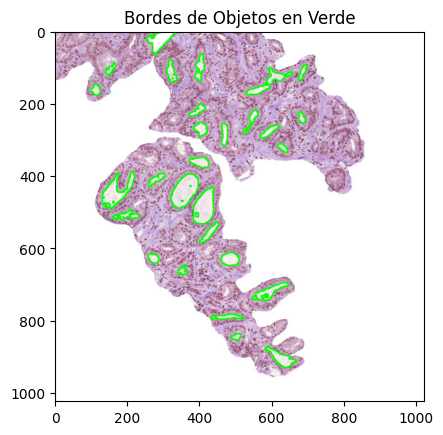

In [10]:
# --- Code to apply borders to the original image ---
# Make a copy of the original image to draw the borders on
img_with_borders = img.copy()

# Find the coordinates of the border pixels (where the value is > 0)
# np.where returns the row and column indices of these pixels
rows, cols = np.where(img_canny > 0)

# Set the BGR values of these pixels to green (0, 255, 0)
# Assuming img_with_borders is a 3-channel image
img_with_borders[rows, cols, 0] = 0   # Blue channel
img_with_borders[rows, cols, 1] = 255 # Green channel
img_with_borders[rows, cols, 2] = 0   # Red channel

# Convert the image to RGB for correct display with matplotlib
img_rgb = cv2.cvtColor(img_with_borders, cv2.COLOR_BGR2RGB)

# Display the final image
plt.imshow(img_rgb)
plt.title('Bordes de Objetos en Verde')
plt.show()

#### 7) Identificar y cropear el lumen más grande

In [ ]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

OTSU Clean Mask Image type: uint8
OTSU Clean Mask pixel max value: 255
The largest region has an area of: 4679.0 pixels


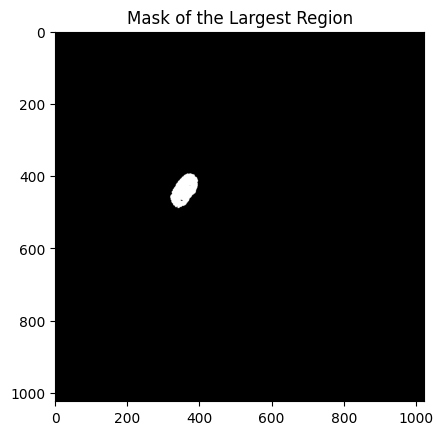

In [11]:
# Vamos a extraer diferentes descriptores geométricos que nos ayudarán a caracterizar los objetos.

mask = img_otsu_clean_expansion.copy()

print(f"OTSU Clean Mask Image type: {mask.dtype}")
print(f"OTSU Clean Mask pixel max value: {mask.max()}")

labeled_image = label(mask)

regions = regionprops(labeled_image)

largest_area = 0
largest_label = 0

for region in regions:
    if region.area > largest_area:
        largest_area = region.area
        largest_label = region.label

print(f"The largest region has an area of: {largest_area} pixels")

# 4. Create a new mask containing only the largest region
largest_region_mask = (labeled_image == largest_label)

# Display the resulting mask
plt.imshow(largest_region_mask, cmap='gray')
plt.title('Mask of the Largest Region')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [ ]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

In [12]:


def max_feret_diameter(binary_image):
    """
    Calculates the maximum Feret's diameter (maximum caliper) of a single object.

    Parameters:
    binary_image (np.ndarray): A binary image (0s and 1s) containing a single object.

    Returns:
    float: The maximum Feret's diameter in pixels. Returns 0 if no object is found.
    """
    # Use regionprops to get the coordinates of the object
    regions = measure.regionprops(binary_image.astype(np.uint8))

    # Check if an object was found
    if not regions:
        return 0

    # Get the coordinates of the pixels in the object's convex hull
    # The 'convex_image' property gives a mask of the convex hull
    convex_coords = np.argwhere(regions[0].convex_image)

    # Check if the convex hull has enough points
    if len(convex_coords) < 2:
        return 0

    # Use scipy's optimized pdist to calculate all pairwise distances on the convex hull
    # This is much faster than a brute-force nested Python loop
    all_distances = distance.pdist(convex_coords, 'euclidean')

    # Return the maximum distance found
    return np.max(all_distances)

In [13]:
# Vamos a extraer diferentes descriptores geométricos que nos ayudarán a caracterizar los objetos.


prop = regionprops(largest_region_mask.astype(np.uint8))

headers = ['Métrica','Valor']
# Initialize the lists to store the metrics
#A, BB, CA, E, ED, EX, MA, MiA, OR, P, S, CO, R = [], [], [], [], [], [], [], [], [], [], [], [], []
#A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R = ['Área'], ['Área de la bounding box'], ['Área convexa'], ['Exentricidad'], ['Diámetro equivalente'], \
#['Extensión'], ['Longitud del eje mayor'], ['Longitud del eje menor'], ['Orientación'], ['Perímetro'], ['Solidez'], ['Compacidad'], ['Rectangularity']

A, BB, CA, E, ED, EX, MA, MiA, OR, P, S, CO = [], [], [], [], [], [], [], [], [], [], [], []
A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO = ['Área'], ['Área de la bounding box'], ['Área convexa'], ['Exentricidad'], ['Diámetro equivalente'], \
['Extensión'], ['Longitud del eje mayor'], ['Longitud del eje menor'], ['Orientación'], ['Perímetro'], ['Solidez'], ['Compacidad']   #, ['Rectangularity']

# Append the metrics for the single object
# You access the properties from prop[0] since there is only one object
A.append(np.round(prop[0].area, 4))
BB.append(np.round(prop[0].bbox_area, 4))
CA.append(np.round(prop[0].convex_area, 4))
E.append(np.round(prop[0].eccentricity, 4))
ED.append(np.round(prop[0].equivalent_diameter, 4))
EX.append(np.round(prop[0].extent, 4))
MA.append(np.round(prop[0].major_axis_length, 4))
MiA.append(np.round(prop[0].minor_axis_length, 4))
OR.append(np.round(prop[0].orientation, 4))
P.append(np.round(prop[0].perimeter, 4))
S.append(np.round(prop[0].solidity, 4))
CO.append(np.round(4 * math.pi * prop[0].area / prop[0].perimeter**2, 4))
#R.append(np.round(prop[0].area / prop[0].bbox_area, 4))

#my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
#          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO), tuple(R)]

my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO)]

print(tabulate(my_data, headers=headers))

max_feret = max_feret_diameter(largest_region_mask)
print(f"Maximum Feret's Diameter: {max_feret:.2f} pixels")


Métrica                      Valor
-----------------------  ---------
Área                     4679
Área de la bounding box  7392
Área convexa             4885
Exentricidad                0.8369
Diámetro equivalente       77.1848
Extensión                   0.633
Longitud del eje mayor    104.778
Longitud del eje menor     57.3502
Orientación                -0.5639
Perímetro                 310.291
Solidez                     0.9578
Compacidad                  0.6107
Maximum Feret's Diameter: 103.45 pixels
